**Data Source:** Pleschberger, Martin, Zernig, Anja, & Kaestner, Andre. (2020). Equipment Sensor Data from Semiconductor Frontend Production (Version 1) [Data set]. Zenodo. http://doi.org/10.5281/zenodo.4282611

In [1]:
import os
import pandas as pd
pd.options.display.max_columns = 10
pd.options.display.max_rows = 10

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report, f1_score

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!head -n 3 equipment1.csv
!echo
!head -n 3 equipment2.csv
!echo
!head -n 3 response.csv

lot;wafer;timestamp;sensor_1;sensor_2;sensor_3;sensor_4;sensor_5;sensor_6;sensor_7;sensor_8;sensor_9;sensor_10;sensor_11;sensor_12;sensor_13;sensor_14;sensor_15;sensor_16;sensor_17;sensor_18;sensor_19;sensor_20;sensor_21;sensor_22;sensor_23;sensor_24
lot2;1;timestamp_0;0.0;0.0;15.1604;105.417;99.18;0.0;2.77728;0.0;1.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;7.0;200.0;151.891;0.0;47.5;0.0;-1.0;19.05
lot2;1;timestamp_1;0.0;0.0;15.092;100.51;98.18;0.0;2.77465;0.0;1.0;0.91;4.0;0.0;0.0;0.0;0.0;0.0;7.0;200.0;151.40200000000004;0.0;48.5;0.0;-1.0;0.99

lot;wafer;timestamp;sensor_25;sensor_26;sensor_27;sensor_28;sensor_29;sensor_30;sensor_31;sensor_32;sensor_33;sensor_34;sensor_35;sensor_36;sensor_37;sensor_38;sensor_39;sensor_40;sensor_41;sensor_42;sensor_43;sensor_44;sensor_45;sensor_46;sensor_47;sensor_48;sensor_49;sensor_50;sensor_51;sensor_52;sensor_53;sensor_54;sensor_55;sensor_56
lot2;1;timestamp_0;0.0;382.64;99.0;11.0;0.0;0.0;0.3055033;1.443347;0.0;1.8520329999999997e-07;61.93445;0.0;0.5188147;0.40

In [3]:
sensors_1_to_24 = pd.read_csv('equipment1.csv', sep=';')
sensors_25_to_56 = pd.read_csv('equipment2.csv', sep=';')
response = pd.read_csv('response.csv', sep=';')

In [4]:
print(sensors_1_to_24.head(3))
print(response.head(3))

    lot  wafer    timestamp  sensor_1  sensor_2  ...  sensor_20  sensor_21  \
0  lot2      1  timestamp_0       0.0       0.0  ...        0.0       47.5   
1  lot2      1  timestamp_1       0.0       0.0  ...        0.0       48.5   
2  lot2      1  timestamp_2       0.0       0.0  ...        0.0       48.0   

   sensor_22  sensor_23  sensor_24  
0        0.0       -1.0      19.05  
1        0.0       -1.0       0.99  
2        0.0       -1.0       0.99  

[3 rows x 27 columns]
    lot  wafer  response class
0  lot2      1    1.0278   bad
1  lot2      2    0.3906  good
2  lot2      3    0.3906  good


In [5]:
print(sensors_1_to_24.shape)
print(sensors_25_to_56.shape)
print(response.shape)

(170896, 27)
(232144, 35)
(2638, 4)


In [6]:
sensors_1_to_24.lot = sensors_1_to_24.lot.str.replace('lot', '').astype('int64')
sensors_1_to_24.timestamp = sensors_1_to_24.timestamp.str.replace('timestamp_', '').astype('int64')

In [7]:
print(sensors_1_to_24['lot'].head(3))
print(sensors_25_to_56['timestamp'].head(3))
print(response['lot'].head(3))

0    2
1    2
2    2
Name: lot, dtype: int64
0    timestamp_0
1    timestamp_1
2    timestamp_2
Name: timestamp, dtype: object
0    lot2
1    lot2
2    lot2
Name: lot, dtype: object


In [8]:
sensors_25_to_56.lot = sensors_25_to_56.lot.str.replace('lot', '').astype('int64')
sensors_25_to_56.timestamp = sensors_25_to_56.timestamp.str.replace('timestamp_', '').astype('int64')

response['class'] = response['class'].replace(['good', 'bad'], [1, 0]).astype('int64')
response.lot = response.lot.str.replace('lot', '').astype('int64')

In [9]:
print(sensors_1_to_24['lot'].head(3))
print(sensors_25_to_56['timestamp'].head(3))
print(response['lot'].head(3))

0    2
1    2
2    2
Name: lot, dtype: int64
0    0
1    1
2    2
Name: timestamp, dtype: int64
0    2
1    2
2    2
Name: lot, dtype: int64


In [10]:
print("Equipment 1 dataset shape:", sensors_1_to_24.shape, \
      '\n'\
      "Equipment 2 dataset shape:", sensors_25_to_56.shape, \
      '\n'\
      "Response dataset shape:", response.shape)

Equipment 1 dataset shape: (170896, 27) 
Equipment 2 dataset shape: (232144, 35) 
Response dataset shape: (2638, 4)


In [11]:
print(sensors_1_to_24.isna().sum())
print(sensors_25_to_56.isna().sum())
print(response.isna().sum())

lot          0
wafer        0
timestamp    0
sensor_1     0
sensor_2     0
            ..
sensor_20    0
sensor_21    0
sensor_22    0
sensor_23    0
sensor_24    0
Length: 27, dtype: int64
lot          0
wafer        0
timestamp    0
sensor_25    0
sensor_26    0
            ..
sensor_52    0
sensor_53    0
sensor_54    0
sensor_55    0
sensor_56    0
Length: 35, dtype: int64
lot         0
wafer       0
response    0
class       0
dtype: int64


In [12]:
sensors_1_to_24 = sensors_1_to_24.groupby(['lot', 'wafer']).mean()
sensors_25_to_56 = sensors_25_to_56.groupby(['lot', 'wafer']).mean()
response = response.groupby(['lot', 'wafer']).mean()

In [13]:
sensor_data = sensors_1_to_24.merge(sensors_25_to_56, on=['lot', 'wafer'], how='outer')
print(sensor_data.shape)
sensor_data.isna().sum()

(1319, 58)


timestamp_x    348
sensor_1       348
sensor_2       348
sensor_3       348
sensor_4       348
              ... 
sensor_52        0
sensor_53        0
sensor_54        0
sensor_55        0
sensor_56        0
Length: 58, dtype: int64

In [14]:
sensor_data.sample(3)

,,timestamp_x,sensor_1,sensor_2,sensor_3,sensor_4,...,sensor_52,sensor_53,sensor_54,sensor_55,sensor_56
lot,wafer,,,,,,,,,,,
81,25,NaN,NaN,NaN,NaN,NaN,...,129.607426,367.235252,0.000007,0.510276,0.647955
67,10,87.5,5.192074,5.280682,13.410573,43.312218,...,123.931678,357.521626,0.000006,0.529075,0.619091
35,7,87.5,5.148781,5.188636,13.417624,42.568432,...,121.631347,0.000007,376.781161,0.490212,0.607955


In [15]:
response.isna().sum()

response    0
class       0
dtype: int64

In [16]:
data = sensor_data.merge(response, on=['lot', 'wafer'], how='outer')
print(data.shape)
data.isna().sum()

(1319, 60)


timestamp_x    348
sensor_1       348
sensor_2       348
sensor_3       348
sensor_4       348
              ... 
sensor_54        0
sensor_55        0
sensor_56        0
response         0
class            0
Length: 60, dtype: int64

In [17]:
data = data.dropna()

In [18]:
data = data.reset_index()
data.head()

,lot,wafer,timestamp_x,sensor_1,sensor_2,...,sensor_54,sensor_55,sensor_56,response,class
0,2,1,87.5,5.231203,5.176705,...,0.000004,0.509069,0.607955,1.0278,0
1,2,2,87.5,5.196315,5.142614,...,396.140498,0.592390,0.642045,0.3906,1
2,2,3,87.5,5.161432,5.255114,...,0.000006,0.526011,0.636648,0.3906,1
3,2,4,87.5,5.175509,5.294318,...,394.003550,0.521722,0.641989,0.4050,1
4,2,5,87.5,5.201729,5.127273,...,0.000007,0.528508,0.641932,0.4050,1


In [19]:
bad_class_sum = (data['class']==0).sum()
good_class_sum = (data['class']==1).sum()
print(bad_class_sum * 100 / (bad_class_sum + good_class_sum),"%")

17.507723995880536 %


In [20]:
def ECDF(df_column):
    '''returns sorted data as x and proportionate 0.0 to 1.0 y values'''
    x = np.sort(df_column)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

def ECDF_plot():
    plt.figure(figsize=(50.0,50.0))
    plt.subplots_adjust(hspace=0.5)
    for ax, n in list(enumerate(data.columns)):
        x, y = ECDF(data[n])
        plt.subplot(10, 10, ax+1)
        plt.grid(True)
        x_ecdf = plt.plot(x, y, marker='.', linestyle='none')
        plt.xlabel('%s readings' %n)
        plt.ylim(0, 1.0)
        plt.yticks(np.arange(0, 1.1, 0.1))
        plt.ylabel('ECDF')
        plt.margins(0.02)
        
#ECDF_plot()     #Uncomment for ECDF plots

In [21]:
print(data.corr()['class'].sort_values().head())
print(data.corr()['response'].sort_values().head())

response    -0.898600
sensor_24   -0.421485
sensor_2    -0.408268
sensor_1    -0.407393
sensor_5    -0.407297
Name: class, dtype: float64
class       -0.898600
sensor_3    -0.373243
sensor_20   -0.372276
sensor_7    -0.338698
sensor_47   -0.286064
Name: response, dtype: float64


**Classification**

In [22]:
target_list = ['response', 'class']
feature_list = list(set(data.columns) - set(target_list))

In [23]:
print(feature_list)

['sensor_55', 'sensor_37', 'sensor_9', 'sensor_31', 'sensor_29', 'sensor_45', 'sensor_16', 'sensor_28', 'sensor_39', 'sensor_2', 'sensor_49', 'sensor_1', 'sensor_34', 'sensor_56', 'sensor_10', 'sensor_24', 'sensor_48', 'lot', 'sensor_27', 'sensor_20', 'sensor_26', 'sensor_38', 'sensor_13', 'sensor_30', 'sensor_8', 'sensor_11', 'sensor_17', 'sensor_7', 'sensor_36', 'sensor_18', 'sensor_35', 'sensor_23', 'sensor_15', 'sensor_33', 'sensor_41', 'sensor_5', 'sensor_12', 'sensor_42', 'sensor_46', 'sensor_52', 'sensor_21', 'sensor_54', 'sensor_50', 'sensor_19', 'wafer', 'sensor_22', 'sensor_40', 'sensor_3', 'timestamp_y', 'sensor_43', 'timestamp_x', 'sensor_25', 'sensor_6', 'sensor_32', 'sensor_4', 'sensor_47', 'sensor_53', 'sensor_14', 'sensor_51', 'sensor_44']


In [24]:
sensor_list = [item for item in feature_list if item.startswith("sensor_")]
print(sensor_list)

['sensor_55', 'sensor_37', 'sensor_9', 'sensor_31', 'sensor_29', 'sensor_45', 'sensor_16', 'sensor_28', 'sensor_39', 'sensor_2', 'sensor_49', 'sensor_1', 'sensor_34', 'sensor_56', 'sensor_10', 'sensor_24', 'sensor_48', 'sensor_27', 'sensor_20', 'sensor_26', 'sensor_38', 'sensor_13', 'sensor_30', 'sensor_8', 'sensor_11', 'sensor_17', 'sensor_7', 'sensor_36', 'sensor_18', 'sensor_35', 'sensor_23', 'sensor_15', 'sensor_33', 'sensor_41', 'sensor_5', 'sensor_12', 'sensor_42', 'sensor_46', 'sensor_52', 'sensor_21', 'sensor_54', 'sensor_50', 'sensor_19', 'sensor_22', 'sensor_40', 'sensor_3', 'sensor_43', 'sensor_25', 'sensor_6', 'sensor_32', 'sensor_4', 'sensor_47', 'sensor_53', 'sensor_14', 'sensor_51', 'sensor_44']


**Sensor Data Scaling**

In [25]:
scaler = StandardScaler()
data[sensor_list] = scaler.fit_transform(data[sensor_list])

In [26]:
X_all_features = data[feature_list]
X_sensors_only = data[sensor_list]

**Test Train split**

In [27]:
X = X_all_features
y = data['class']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [29]:
print(type(X_train))
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

<class 'pandas.core.frame.DataFrame'>
(776, 60)
(776,)
(195, 60)
(195,)


**Logistic Regression Classification before dummy encoding**

In [30]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [31]:
y_pred_train = log_reg.predict(X_train)
y_pred_test = log_reg.predict(X_test)

              precision    recall  f1-score   support

           0       0.57      0.52      0.54        31
           1       0.91      0.93      0.92       164

    accuracy                           0.86       195
   macro avg       0.74      0.72      0.73       195
weighted avg       0.86      0.86      0.86       195

              precision    recall  f1-score   support

           0       0.67      0.46      0.55       139
           1       0.89      0.95      0.92       637

    accuracy                           0.86       776
   macro avg       0.78      0.71      0.73       776
weighted avg       0.85      0.86      0.85       776



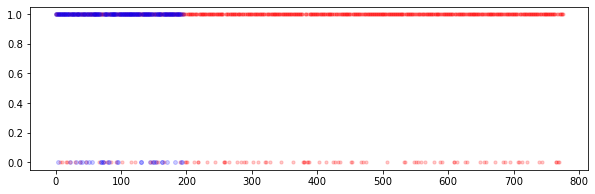

In [32]:
plt.figure(figsize=(10,3))
plt.ylim(-0.05, 1.05)

plt.scatter(np.arange(len(y_train)), y_pred_train, c='red', s=10, alpha=0.2);
plt.scatter(np.arange(len(y_test)), y_pred_test, c='blue', s=15, alpha=0.2);

print(classification_report(y_test, y_pred_test))
print(classification_report(y_train, y_pred_train))

**Feature Engineering** - **Dummy Encoding lots**

In [33]:
data_lot_encoded = pd.get_dummies(data, columns=['lot'])

In [34]:
print(data_lot_encoded.shape)
data_lot_encoded.head();

(971, 101)


In [35]:
data_lot_encoded.columns;

targets = ['response', 'class']
features = list(set(data_lot_encoded.columns)-set(target_list))

In [36]:
X = data_lot_encoded[features]
y = data_lot_encoded['class']

In [37]:
print(X.shape, y.shape)
X.sample(3)

(971, 99) (971,)


,lot_6,lot_49,lot_29,sensor_9,sensor_31,...,sensor_53,lot_2,sensor_14,lot_40,sensor_44
178,0,0,0,0.971985,0.447592,...,-1.000726,0,0.633594,0,-0.217720
614,0,0,0,-1.128033,-0.203372,...,-1.000726,0,-1.865000,0,-0.414194
507,0,0,0,-1.128033,-0.818307,...,0.868374,0,-0.731174,0,-0.348703


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.2)

**Logistic regression**

In [39]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [40]:
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

In [41]:
print(classification_report(y_test, y_test_pred))
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.65      0.77      0.70        26
           1       0.96      0.93      0.95       169

    accuracy                           0.91       195
   macro avg       0.80      0.85      0.83       195
weighted avg       0.92      0.91      0.92       195

              precision    recall  f1-score   support

           0       0.79      0.77      0.78       144
           1       0.95      0.95      0.95       632

    accuracy                           0.92       776
   macro avg       0.87      0.86      0.87       776
weighted avg       0.92      0.92      0.92       776



**Decision Tree**

In [42]:
list(np.arange(1,3))

[1, 2]

In [43]:
log_hyper = {'penalty':'L2', 'max_iter':1000, 'class_weight':0}
decision_hyper = {'criterion':'gini', 'max_depth':2, 'class_weight':0}

In [44]:
fail_f1_score = []
for depth in np.arange(1,31):
    decision_tree = tree.DecisionTreeClassifier(max_depth=depth)
    decision_tree.fit(X_train, y_train)
    y_train_pred = decision_tree.predict(X_train)
    y_test_pred = decision_tree.predict(X_test)
    fail_f1_score.append(f1_score(y_test, y_test_pred, pos_label=0))

2 , 0.7419354838709676


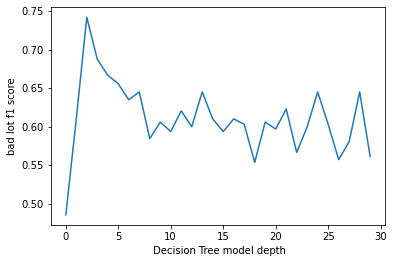

In [45]:
plt.plot(np.arange(len(fail_f1_score)), fail_f1_score)
plt.xlabel(' Decision Tree model depth', size=10)
plt.ylabel('bad lot f1 score', size=10)
print(fail_f1_score.index(max(fail_f1_score)), ',', max(fail_f1_score))
best_depth = fail_f1_score.index(max(fail_f1_score))

In [46]:
decision_tree = tree.DecisionTreeClassifier(max_depth=best_depth)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [47]:
y_train_pred = decision_tree.predict(X_train)
y_test_pred = decision_tree.predict(X_test)

In [48]:
print(f1_score(y_test, y_test_pred, pos_label=0))
print(classification_report(y_test, y_test_pred))
print(classification_report(y_train, y_train_pred))

0.6101694915254238
              precision    recall  f1-score   support

           0       0.55      0.69      0.61        26
           1       0.95      0.91      0.93       169

    accuracy                           0.88       195
   macro avg       0.75      0.80      0.77       195
weighted avg       0.90      0.88      0.89       195

              precision    recall  f1-score   support

           0       0.68      0.69      0.69       144
           1       0.93      0.93      0.93       632

    accuracy                           0.88       776
   macro avg       0.81      0.81      0.81       776
weighted avg       0.88      0.88      0.88       776



In [49]:
decision_tree.classes_

array([0, 1])

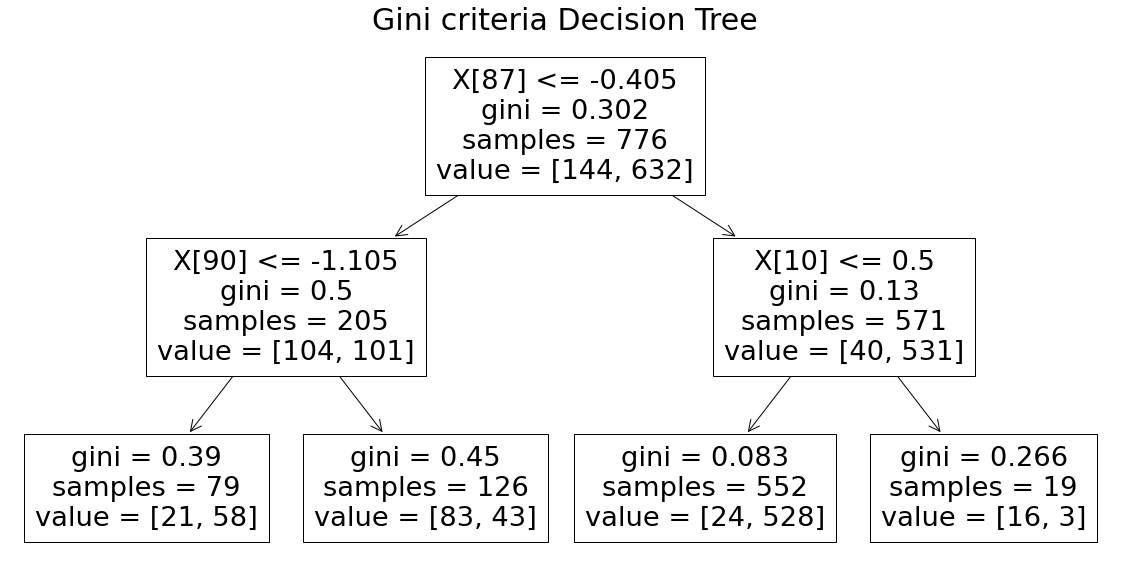

In [50]:
plt.figure(figsize=(20,10))
decision_tree_plot = tree.plot_tree(decision_tree)
plt.title('Gini criteria Decision Tree', size=30)
plt.show()

**Random Forest**

In [51]:
fail_f1_score = []
for estimator in np.arange(1,31):
    rand_for = RandomForestClassifier(n_estimators=estimator)
    rand_for.fit(X_train, y_train)
    y_train_pred = rand_for.predict(X_train)
    y_test_pred = rand_for.predict(X_test)
    fail_f1_score.append(f1_score(y_test, y_test_pred, pos_label=0))

19 , 0.7241379310344829


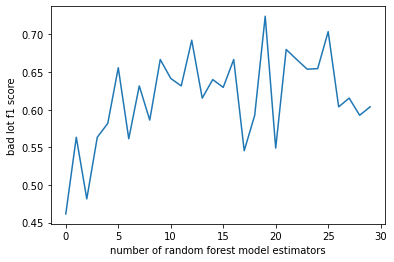

In [52]:
plt.plot(np.arange(len(fail_f1_score)), fail_f1_score)
plt.xlabel('number of random forest model estimators', size=10)
plt.ylabel('bad lot f1 score', size=10)
print(fail_f1_score.index(max(fail_f1_score)), ',', max(fail_f1_score))
best_estimators = fail_f1_score.index(max(fail_f1_score))

In [53]:
rand_for = RandomForestClassifier(n_estimators=best_estimators)
rand_for.fit(X_train, y_train)

RandomForestClassifier(n_estimators=19)

In [54]:
y_train_pred = rand_for.predict(X_train)
y_test_pred = rand_for.predict(X_test)

In [55]:
print(classification_report(y_test, y_test_pred, labels=[0,1]))
print(classification_report(y_train, y_train_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.56      0.54      0.55        26
           1       0.93      0.93      0.93       169

    accuracy                           0.88       195
   macro avg       0.74      0.74      0.74       195
weighted avg       0.88      0.88      0.88       195

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       144
           1       1.00      1.00      1.00       632

    accuracy                           1.00       776
   macro avg       1.00      1.00      1.00       776
weighted avg       1.00      1.00      1.00       776



In [56]:
rand_for = RandomForestClassifier(n_estimators=200)
rand_for.fit(X_train, y_train)
y_train_pred = rand_for.predict(X_train)
y_test_pred = rand_for.predict(X_test)
f1_score(y_test, y_test_pred, pos_label=0)

0.6538461538461539